In [1]:
#Imports needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import seaborn as sns
import string as st
import openpyxl
import re

ModuleNotFoundError: No module named 'openpyxl'

In [42]:
df_kpi=pd.read_excel('Oi-Brazil-20210507/18_Attempt_per_AS-IMSCSF-IMSNFM-raw-PM_14810-2021_05_07-01_22_46__878.xlsx',
                     sheet_name='Data')

In [43]:
# First line contains non related data and can be deleted
# Dropping first line
df_kpi.drop(index=0, inplace=True)
df_kpi.reset_index(drop=True, inplace=True)

df_kpi.head(5)

,Period start time,IMSNFM name,AttemptPerAS (AttemptPerAS)
0,2021-04-22 01:30:00,IMSNFM-1,689
1,2021-04-22 01:45:00,IMSNFM-1,515
2,2021-04-22 02:00:00,IMSNFM-1,571
3,2021-04-22 02:15:00,IMSNFM-1,591
4,2021-04-22 02:30:00,IMSNFM-1,452


# Understanding the Data

## KPI (PM Counters) in the dataset

| KPI ID | KPI Alias | KPI Title | KPI Formula | Unit |
|:-|:-|:-|:-|:-:|
|AttemptPerAS|S-CSCF Invite Attempt towards AS during last period of time|S-CSCF Invite Attempt towards AS during last period of time|ASP3.AttemptPerAS|Count No.|


## VNFds contributing with data
The dataset is formed by Counters retrieved in a medium size VNF, so several VNFds are involved. The result is aggregated by site, being IMSNFM-1 related to site *Arcos*, IMSNFM-2 related to site *Mario Pires*, IMSNFM-3 retated to site *Boa Viagem* and IMSNFM-4 related to site .


In [44]:
# Unique method is used to show all names of VNFd are in dataset
df_vnfdNames=pd.DataFrame(df_kpi['IMSNFM name'].unique())

siteNames = list(df_vnfdNames[0])

siteNames

['IMSNFM-1', 'IMSNFM-2', 'IMSNFM-3', 'IMSNFM-4']

# Cleaning up data
This is a common procedure for Data Analysis.
First get rid of missing data.

In [45]:
# The technique used in this example will be drop missing data, meaning all row of the datasets in the list will be erased.
# Other techniques can be applied depending upon the case.
#for kpis in SCSCF_KPIs:
#    kpis.dropna()
df_kpi.isnull().sum().sum()

0

In [46]:
#An understanding of the datatypes is important, because statistics needs numbers.
df_kpi.dtypes

Period start time              datetime64[ns]
IMSNFM name                            object
AttemptPerAS (AttemptPerAS)            object
dtype: object

In [47]:
# AttemptPerAS is casted to numeric
df_kpi['AttemptPerAS (AttemptPerAS)'] = pd.to_numeric(df_kpi['AttemptPerAS (AttemptPerAS)'])

df_kpi.dtypes   

Period start time              datetime64[ns]
IMSNFM name                            object
AttemptPerAS (AttemptPerAS)             int64
dtype: object

# Anomaly detection using LSTM Auto-encoder
Here we will use SCSCFINVATTEMPTPERS PM Counter to look for anomalies. 

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
import seaborn as sns
from datetime import datetime

# Using only one SCSCF, chosen at random to train the data.

In the list of dataframes SCSCF_KPI, we will work with $i^{th}$ element

In [51]:
site=0
# Split dataframe in two, being about 70% for taining and 30% for testing
siteName_kpi=df_kpi.loc[df_kpi['IMSNFM name']==siteNames[site]]

#train = siteName_kpi.loc[siteName_kpi['Period start time'] <= datetime(2021, 3, 20, 21, 15)]
train = siteName_kpi.loc[siteName_kpi['Period start time'] <= datetime(2021, 5, 2, 10, 30)]
test = siteName_kpi.loc[siteName_kpi['Period start time'] > datetime(2021, 5, 2, 10, 30)]
#test = siteName_kpi.loc[siteName_kpi['Period start time'] > datetime(2021, 3, 20, 21, 15)]


# Normalization

Normalization is needed because the LSTM uses $tanh$ and $sigmoid$ functions. These functions works better if the data is contained in an interval between $-\varepsilon<x<\varepsilon$, where epsilon is auto defined by the sci-kit scaler, and $x$ is the scaled input variable.

This procedure is part of the **Normalization/Windowing** block of the LSTM-AE discussed above, reproduced here for convenience.
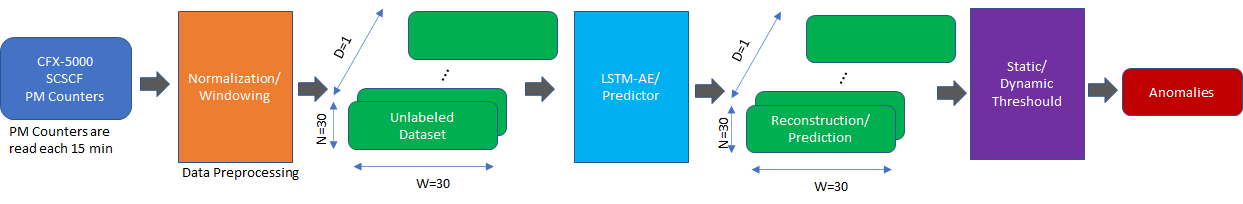

In [52]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(train[['AttemptPerAS (AttemptPerAS)']])

train['AttemptPerAS (AttemptPerAS)'] = scaler.transform(train[['AttemptPerAS (AttemptPerAS)']])
test['AttemptPerAS (AttemptPerAS)'] = scaler.transform(test[['AttemptPerAS (AttemptPerAS)']])

<ipython-input-52-8e4c3207fde1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['AttemptPerAS (AttemptPerAS)'] = scaler.transform(train[['AttemptPerAS (AttemptPerAS)']])
<ipython-input-52-8e4c3207fde1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['AttemptPerAS (AttemptPerAS)'] = scaler.transform(test[['AttemptPerAS (AttemptPerAS)']])


# Windowing

In [53]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

seq_size = 8  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['AttemptPerAS (AttemptPerAS)']], train['AttemptPerAS (AttemptPerAS)'], seq_size)
testX, testY = to_sequences(test[['AttemptPerAS (AttemptPerAS)']], test['AttemptPerAS (AttemptPerAS)'], seq_size)

In [54]:
trainX.shape

(989, 8, 1)

# LSTM-AE model
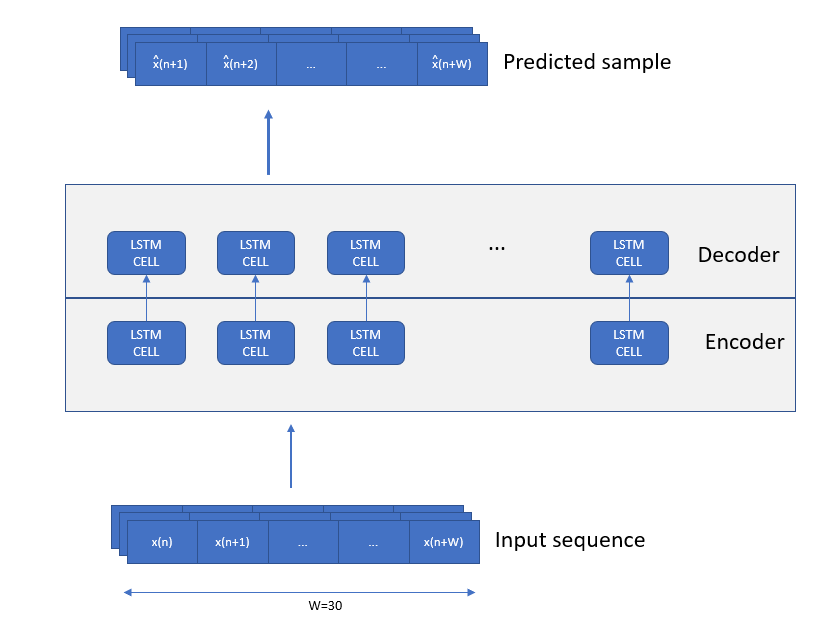

In [55]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

################################
#model = Sequential()
#model.add(LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(rate=0.2))

#model.add(RepeatVector(trainX.shape[1]))

#model.add(LSTM(256, return_sequences=True))
#model.add(Dropout(rate=0.2))
#model.add(TimeDistributed(Dense(trainX.shape[2])))
#model.compile(optimizer='adam', loss='mae')
#model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 128)            66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 8, 64)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 64)             33024     
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 128)            98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 8, 1)              129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

Epoch 1/30
112/112 [==============================] - 2s 15ms/step - loss: 0.6175 - val_loss: 0.0801
Epoch 2/30
112/112 [==============================] - 1s 11ms/step - loss: 0.3017 - val_loss: 0.0259
Epoch 3/30
112/112 [==============================] - 1s 11ms/step - loss: 0.2307 - val_loss: 0.0278
Epoch 4/30
112/112 [==============================] - 1s 12ms/step - loss: 0.1978 - val_loss: 0.0150
Epoch 5/30
112/112 [==============================] - 2s 14ms/step - loss: 0.2024 - val_loss: 0.0261
Epoch 6/30
112/112 [==============================] - 2s 14ms/step - loss: 0.1905 - val_loss: 0.0098
Epoch 7/30
112/112 [==============================] - 2s 14ms/step - loss: 0.1801 - val_loss: 0.0133
Epoch 8/30
112/112 [==============================] - 2s 14ms/step - loss: 0.1955 - val_loss: 0.0135
Epoch 9/30
112/112 [==============================] - 2s 15ms/step - loss: 0.1882 - val_loss: 0.0126
Epoch 10/30
112/112 [==============================] - 2s 15ms/step - loss: 0.1803 - val_lo

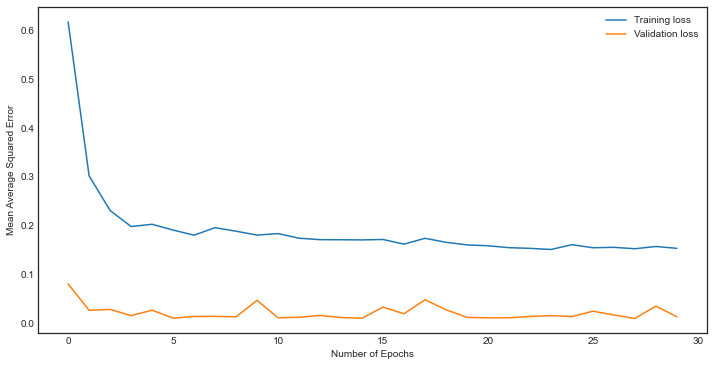

In [56]:
# fit model
history = model.fit(trainX, trainY, epochs=30, batch_size=8, validation_split=0.1, verbose=1)

plt.figure(figsize=(12,6))
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Average Squared Error")
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

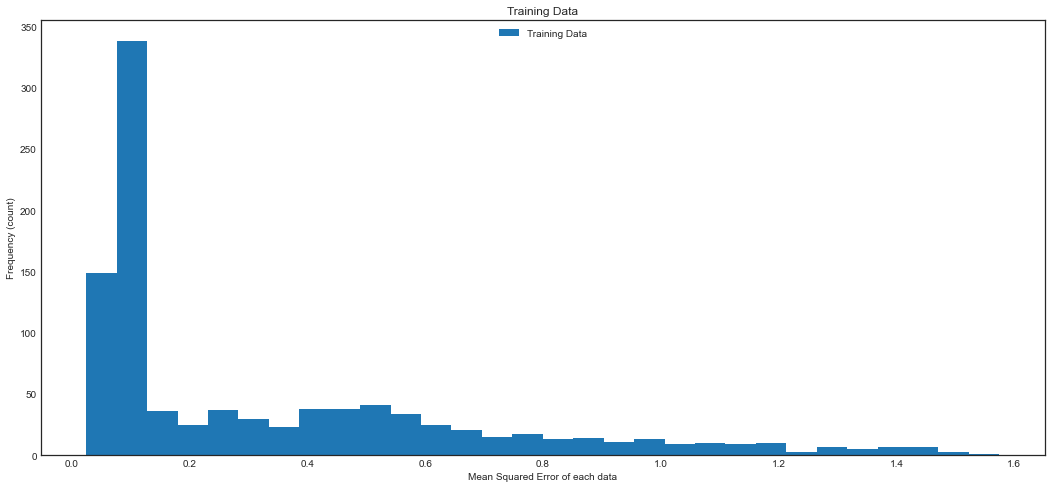

In [57]:
###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction
plt.figure(figsize=(18,8))
plt.xlabel("Mean Squared Error of each data")
plt.ylabel("Frequency (count)")
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30, label="Training Data")
plt.legend(loc=9)
plt.title('Training Data')
plt.show()


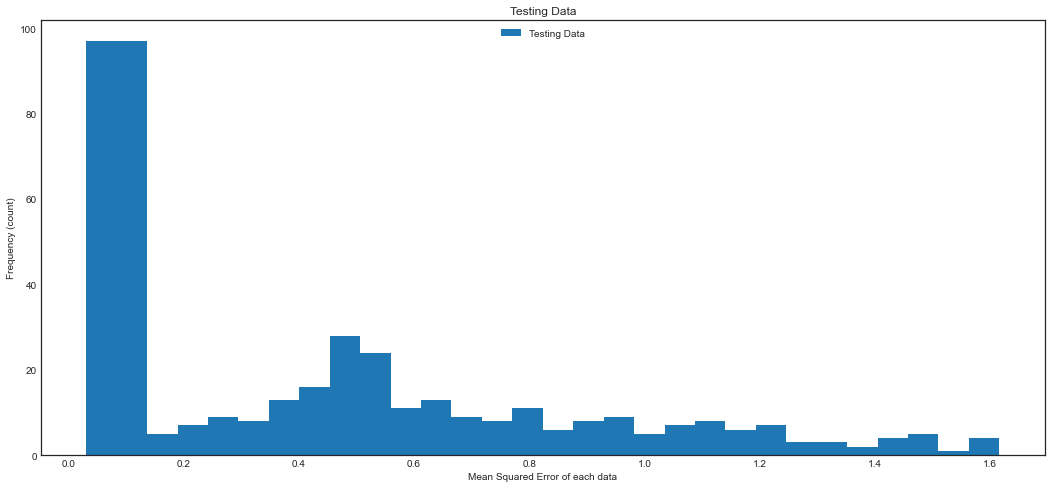

In [58]:
plt.figure(figsize=(18,8))
plt.xlabel("Mean Squared Error of each data")
plt.ylabel("Frequency (count)")
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30, label="Testing Data")
plt.legend(loc=9)
plt.title('Testing Data')
plt.show()

# Anomalies detected

Simple threshould defined, based on the frequency of errors. This is the hyperparameter to tune the system.

In [63]:
max_trainMAE = 1.65  #or Define 90% value of max as threshold.

In [64]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['AttemptPerAS (AttemptPerAS)'] = test[seq_size:]['AttemptPerAS (AttemptPerAS)']

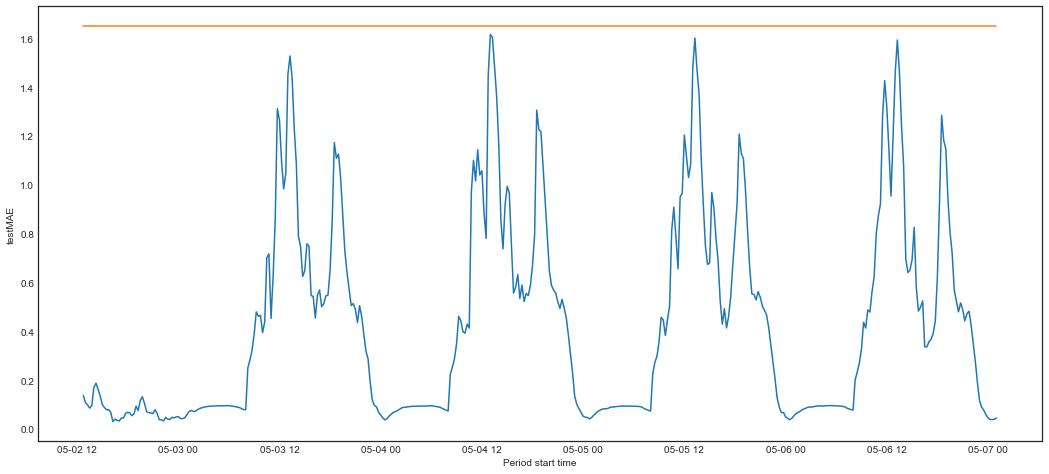

In [65]:
#Plot testMAE vs max_trainMAE
plt.figure(figsize=(18,8))
sns.lineplot(x=anomaly_df['Period start time'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Period start time'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

<AxesSubplot:xlabel='Period start time'>

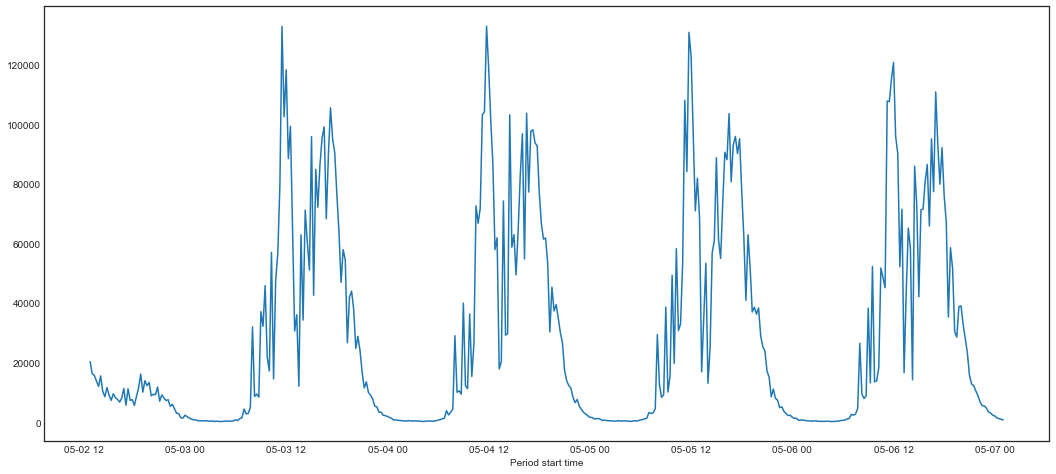

In [66]:
#Plot anomalies
plt.figure(figsize=(18,8))
sns.lineplot(x=anomaly_df['Period start time'], y=scaler.inverse_transform(anomaly_df['AttemptPerAS (AttemptPerAS)']))
sns.scatterplot(x=anomalies['Period start time'], y=scaler.inverse_transform(anomalies['AttemptPerAS (AttemptPerAS)']), color='r')
